    This solves for the evolution of a wavepacket in momentum space using a continuous distribution. Instead of having one point per Brillioun zone, we set up a grid over each Brillion zone that approximates a continuum. Since the potential can only couple momentum states that differ by 2k, we effectively have a set of uncoupled differential equations, one for each point in the first Brillion zone. 
    
    First, let's define some simple functions and plot the bandstructure of the Hamiltonian

In [174]:
# dictionary of parameters, many of which are not needed in continuous position or discrete momentum simulations
function return_params(;x_step = 0.04, t_step = 0.015, 
                        lower_bdry = -20.0, upper_bdry = 20.0, 
                        t_propagate = 10, t_load = 3pi, n_bloch = 1, 
                        n_ramp = 0.2, n_lat_dep = 1.5, v0 = 0.1, dv = 0.2,
                        n_reduce_x = 1, n_reduce_t = 1, œâ_0 = 0, 
                        k_max = 6, n_dk = 2, l_max = 30, 
                        Œîx = 0, œï = 0, theta = 0, x0 = 0, dn = 0) # default values of paramters
    
    grav_ramp = 0.8576;
    ramp_rate = grav_ramp * n_ramp;
    bloch_period = 8/ramp_rate;
    
    t_bloch = (n_bloch + dn) * bloch_period;
    t_total = 2*t_load + t_bloch + t_propagate;
    dx = 1/(2*dv);
    xs = lower_bdry*dx : x_step : upper_bdry*dx;
    ts = 0 : t_step : t_total;
    
    n_k = 2k_max + 1;  # for discrete momentum basis
    n_l = 2l_max + 1;  # for discrete position basis
    
    # used to match conditions of continuous position and discrete position bases;
    # each lattice site is of length œÄ
    lower_l_max = Int(floor(lower_bdry*dx/pi));
    upper_l_max = Int(ceil(upper_bdry*dx/pi));
    n_l_match = upper_l_max - lower_l_max + 1;
    
    params = Dict("x_step" => x_step,
                  "t_step" => t_step,
                  "lower_bdry" => lower_bdry, 
                  "upper_bdry" => upper_bdry,
                  "t_propagate" => t_propagate, 
                  "t_load" => t_load, 
                  "n_bloch" => n_bloch, 
                  "t_total" => t_total,
                  "n_ramp" => n_ramp, 
                  "n_lat_dep" => n_lat_dep, 
                  "grav_ramp" => grav_ramp, 
                  "ramp_rate" => ramp_rate, 
                  "bloch_period" => bloch_period,
                  "t_bloch" => t_bloch,
                  "v0" => v0,  
                  "dv" => dv,
                  "x0" => x0,
                  "dx" => dx, 
                  "xs" => xs,
                  "ts" => ts,
                  "n_reduce_x" => n_reduce_x, 
                  "n_reduce_t" => n_reduce_t,
                  "œâ_0" => œâ_0,
                  "k_max" => k_max,
                  "n_k" => n_k,
                  "n_dk" => n_dk,
                  "l_max" => l_max,
                  "n_l" => n_l,
                  "œï" => œï,
                  "Œîx" => Œîx,
                  "lower_l_max" => lower_l_max,
                  "upper_l_max" => upper_l_max,
                  "n_l_match" => n_l_match,
                  "theta" => theta,
                  "dn" => dn);
    return params
end

return_params (generic function with 1 method)

In [175]:
# discrete momentum space things
using LinearAlgebra
using PyPlot
using Printf

# Bloch oscillation Hamiltonian in discrete momentum basis 
function ham_BO_eigs(ts, params)
    k_max = params["k_max"];
    n_k = params["n_k"];
    n_lat_dep = params["n_lat_dep"];
    ramp_rate = params["ramp_rate"];
    # make an array of hamiltonians for each t in ts
    Ham = [];
    for t = 1:length(ts)
        kinetic_energy = [0.5(2k - ramp_rate*ts[t]/4)^2 for k = -k_max:k_max];
        Ham = push!(Ham, SymTridiagonal(kinetic_energy, (n_lat_dep./2).*ones(n_k - 1)));
    end
    return Ham
end

# E(t)s for each H(t) for t in ts
function energy_over_time(ts, params)
    # get an array of Hamiltonians for each t in ts
    ham = ham_BO_eigs(ts, params);
    # array of eigenvalues/energies for each Hamiltonian of t in ts
    eig_vals = [];
    for t=1:length(ts)
        eig_vals = push!(eig_vals, eigvals(SymTridiagonal(real.(ham[t]))));
    end
    # make an array of arrays into a matrix whose i-th row contains the i-th element the inner arrays prior
    eig_vals = hcat(eig_vals...); 
    return eig_vals
end

function plot_bandstructure(ts, dt, eig_vals; rows_to_graph=4)
    # graph each energy band if there are more bands than rows_to_graph.
    if size(eig_vals, 1) >= rows_to_graph
        for i = 1:rows_to_graph 
            PyPlot.plot(ts, eig_vals[i, :]);
            
            # annotation test
            t_index = Int(round(30/dt));
            x = ts[t_index];
            y = eig_vals[i, :][t_index];
            PyPlot.plot([x], [y], "ko");
            r_label = @sprintf "(%1.2f, %2.2f)" x y;
            PyPlot.annotate(r_label,
            xy=(x, y),  
            xytext=(x+1, y+0))
        end
    end
end

plot_bandstructure (generic function with 1 method)

In [176]:
using Printf

params = return_params(n_ramp=0.2);
t_bloch = params["t_bloch"];
dt = params["t_step"];
ts = 0:dt:t_bloch;
eig_vals = energy_over_time(ts, params);
# PyPlot.figure();
PyPlot.figure(figsize=(8,5));
plot_bandstructure(ts, dt, eig_vals);
PyPlot.show();

    Now, let's dive in a little deeper and set up a full simulation of dynamics starting with a plane wave state (one point in momentum space).

In [177]:
function unit_step(x)
   if x<0
        return 0
    else
        return 1
    end
end

function ham_BO(k0,t,params)
    k_max = params["k_max"];
    n_k = params["n_k"];
    n_lat_dep = params["n_lat_dep"];
    ramp_rate = params["ramp_rate"];
    t_load = params["t_load"];
    t_bloch = params["t_bloch"];
    
    kinetic_energy =unit_step(t_load-t).*[0.5(2k + k0)^2 for k = -k_max:k_max] + 
        unit_step(t-t_load)*unit_step(t_load + t_bloch - t).*[0.5(2k + k0 - ramp_rate*(t-t_load)/4)^2 for k = -k_max:k_max] + 
        unit_step(t - t_load - t_bloch).*[0.5(2k + k0 - ramp_rate*t_bloch/4)^2 for k = -k_max:k_max];
    
    coupling = (n_lat_dep./4)*(t/t_load*unit_step(t)*unit_step(t_load-t) + unit_step(t-t_load)*unit_step(t_load + t_bloch - t) +
        (t_load - t + t_load + t_bloch)/t_load*unit_step(t - t_load - t_bloch)*unit_step(2*t_load + t_bloch - t));
    
    Ham = SymTridiagonal(kinetic_energy, coupling.*ones(n_k - 1));
    return Ham
end

ham_BO (generic function with 1 method)

In [178]:
using DifferentialEquations

function œà0_plane_wave(k)
    if k==0
        return 1
    else
        return 0
    end
end

function solve_SE(k0,params)
    # system of equations with wavefunction separated into real and imaginary parts
    function coupled_SE(du, u, p, t)
        H = ham_BO(k0,t,params);
        du[1, :] = H * u[2, :];
        du[2, :] = -1 .* H * u[1, :];
    end
    
    k_max = params["k_max"];
    n_k = params["n_k"];
    t_bloch = params["t_bloch"];
    t_load = params["t_load"];
    t_propagate = params["t_propagate"];
    
    # initial wavefunction where all of imaginary part is zero
    œà0_real = [œà0_plane_wave(l) for l = -k_max:k_max];
    œà0_imag = zeros(n_k);
    œà0 = [œà0_real'; œà0_imag'];
    
    tspan = (0.0, 2t_load + t_bloch + t_propagate);
    
    @time sols = solve(ODEProblem(coupled_SE, œà0, tspan), reltol=1e-4);
    # the number of solutions is the number of time steps the solver returned
    ts = sols.t;
    nTs = length(sols.t);
    œàf = zeros(n_k, nTs) .+ 0im;
    
    for t = 1:nTs
        sol = sols.u[t];
        # wavefunction at the t-th time step, combining the real and imaginary components
        œàt = [complex(real, imag) for (real, imag) in zip(sol[1,:], sol[2,:])];
        œàf[:, t] = œàt;
    end
    return œàf, ts
end

solve_SE (generic function with 1 method)

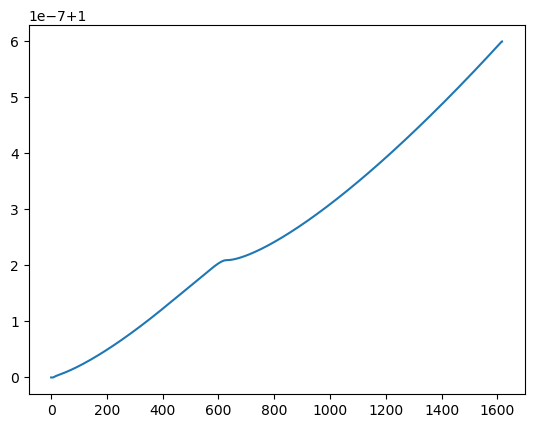

 11.998640 seconds (33.51 M allocations: 7.952 GiB, 6.47% gc time)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000058C1A1D0>

In [179]:
params = return_params(n_ramp=1, n_dk=10, n_lat_dep=2, t_propagate=10, k_max=4, n_bloch=1, t_load=20, v0=0);

œàf,ts = solve_SE(0.4,params);
prob_œà_0 = (abs.(œàf[params["k_max"]+1,:])).^2;
prob_œà_1 = (abs.(œàf[params["k_max"]+2,:])).^2;
PyPlot.figure();
PyPlot.title("Plane wave state evolution");
PyPlot.ylabel("Wavefunction Amplitude");
PyPlot.xlabel("Time [œâ‚Åª¬π]");
# plot_localization_length_vs_latdep(lat_deps, n_ramp=r, label="without assumption (continuous)");
PyPlot.plot(ts, prob_œà_0, ts, prob_œà_1);

function normalize(œà)
    return sum(abs.(œà).^2)
end

temp = zeros(length(ts))
for j = 1:length(ts)
    temp[j] = normalize(œàf[:,j])
end
    

PyPlot.figure()
PyPlot.plot(temp)

    Going deeper still.... let's now simulate a bunch of points in momentum space, then combine them at the end to get a picture of the full state evolution. 

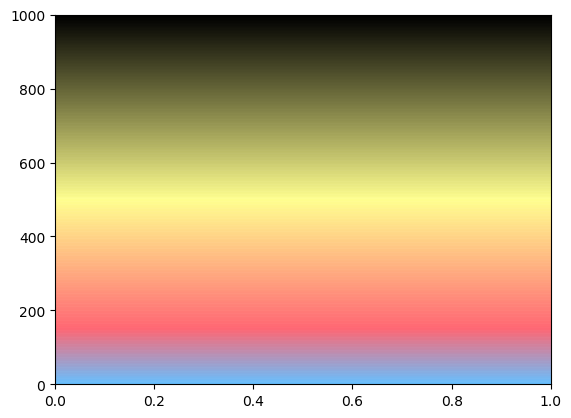

PyObject <matplotlib.collections.QuadMesh object at 0x000000000329A240>

In [180]:
using PyPlot, Colors  # I don't think I ever use Colors...?
#Make my own colormap üçé!
#I'm trying to replicate the CMYK colormap in Mathematica. This colormap also exists in Julia, but
#I don't think it's compatible with the matplotlib functions. Anyways, it's cooler to make your own.

#I haven't made this very general yet, so changing n_colors doesn't automatically update everything else. 
n_colors = 4;
c = zeros((n_colors, 4));

#format is [r,g,b,Œ±], where Œ± is the transparency.
c[1,:] = [.4, .75, 1, .7];
c[2,:] = [1, .4, 0.45, .7];
c[3,:] = [1, 1, .55, .6];
c[4,:] = [0, 0, 0, 1.0];

#Set the limits for when the colors change. For example, if lim1 = .15, then the color will reach that of c[2,:]
# by the time the function reaches 0.15*(f_max - f_min). 
lim1 = 0.15;
lim2 = 0.5;

#You need a weird data structure for making a colormap, see the PyPlot matplotlib documentation.
ctable = [[(0.0, c[1,i], c[1,i]), (lim1, c[2,i], c[2,i]), (lim2, c[3,i], c[3,i]), (1.0, c[4,i], c[4,i])] for i=1:4];

üçé = ColorMap("üçé", ctable[1], ctable[2], ctable[3], ctable[4])

A = [i for i=1:1000, j=1:1]

pcolormesh(A, cmap = üçé)

In [181]:
function ham_BO_dx(k0,t,params)
    k_max = params["k_max"];
    n_k = params["n_k"];
    n_lat_dep = params["n_lat_dep"];
    ramp_rate = params["ramp_rate"];
    t_load = params["t_load"];
    t_bloch = params["t_bloch"];
    theta = params["theta"];
    
    kinetic_energy =unit_step(t_load-t).*[0.5(2k + k0)^2 for k = -k_max:k_max] + 
        unit_step(t-t_load)*unit_step(t_load + t_bloch - t).*[0.5(2k + k0 - ramp_rate*(t-t_load)/4)^2 for k = -k_max:k_max] + 
        unit_step(t - t_load - t_bloch).*[0.5(2k + k0 - ramp_rate*t_bloch/4)^2 for k = -k_max:k_max];
    
    coupling = (n_lat_dep./4)*(t/t_load*unit_step(t)*unit_step(t_load-t) + unit_step(t-t_load)*unit_step(t_load + t_bloch - t) +
        (t_load - t + t_load + t_bloch)/t_load*unit_step(t - t_load - t_bloch)*unit_step(2*t_load + t_bloch - t));
    
    Ham = Tridiagonal(exp(theta*1im)*coupling.*ones(n_k - 1), (1. + 0.0im).*kinetic_energy, exp(-theta*1im)*coupling.*ones(n_k - 1));
    return Ham
end

function œà0_gaussian(params)
    n_dk = params["n_dk"];
    n_k = params["n_k"];
    v0 = params["v0"];
    dv = params["dv"];
    k_max = params["k_max"];
    x0 = params["x0"];
    
    œà0 = zeros(2(2n_dk),n_k);
    for i = 1:2n_dk
        k0 = (i - n_dk)/n_dk;
        œà0_real = [cos((2k+k0-v0)*x0).*exp(-(2k+k0-v0)^2/dv^2) for k = -k_max:k_max];
        œà0_imag = [sin((2k+k0-v0)*x0).*exp(-(2k+k0-v0)^2/dv^2) for k = -k_max:k_max];
        œà0[2i-1,:] = œà0_real;
        œà0[2i,:] = œà0_imag;
    end
    
    return œà0
end

function normalization(œà0)
    return sum(abs.(œà0)^2)
end

# system of equations with wavefunction separated into real and imaginary parts
# There are coupled sets of equations for each point in the first Brillioun Zone, 
# created by looping over i
function coupled_SE_continuous(du, u, p, t)
    H = ham_BO_dx(0,t,params);
    n_dk = Int(params["n_dk"]);
    for i=1:2n_dk
        H = ham_BO((i-n_dk)/n_dk,t,params);
        du[2i-1, :] = H * u[2i, :];
        du[2i, :] = -1 * H * u[2i-1, :];
    end
end

# This function just reformats the final solution into a 2D object, first index is momentum, second is time
function join_solution(sol, œàtot, params)
    n_dk = params["n_dk"];
    n_k = params["n_k"];
    for i = 1:2n_dk
        œàtot[i:2n_dk:(i+2n_dk*(n_k-1))] = [complex(real, imag) for (real, imag) in zip(sol[2i-1,:], sol[2i,:])];
    end
    return œàtot
end

function solve_SE_continuous(params, œà0)
    k_max = params["k_max"];
    n_k = params["n_k"];
    n_dk = Int(params["n_dk"]);
    t_bloch = params["t_bloch"];
    t_load = params["t_load"];
    t_propagate = params["t_propagate"];
    
    # Solve for evolution
    tspan = (0.0, 2t_load + t_bloch + t_propagate);
    @time sols = solve(ODEProblem(coupled_SE_continuous, œà0, tspan), reltol=1e-5);
    ts = sols.t;
    nTs = length(sols.t);
    œàf = zeros(2n_dk*n_k,nTs) .+ 0.0im;
    œàtot = (1 + 0im).*zeros(2n_dk*n_k);

    # Reformat final state object for each timestep
    for t = 1:nTs
        sol = sols.u[t];
        if t==1
            print(size(sol))
        end
        # wavefunction at the t-th time step, combining the real and imaginary components
        # and combining onto one momentum axis
        œàf[:, t] = join_solution(sol, œàtot, params);
    end
    
    return œàf, ts
end

solve_SE_continuous (generic function with 1 method)

In [269]:
params = return_params(n_ramp=1, n_dk=6, n_lat_dep=9, t_propagate=10, k_max=10, n_bloch=5, v0=0, dv=1, t_load=6pi, x0=0.5pi, dn=0.5);
# initial wavefunction where all of imaginary part is zero, using finite temperature from params
œà0 = œà0_gaussian(params);
œàf, ts = solve_SE_continuous(params, œà0);

 35.544948 seconds (309.80 M allocations: 17.630 GiB, 18.05% gc time)
(24, 21)

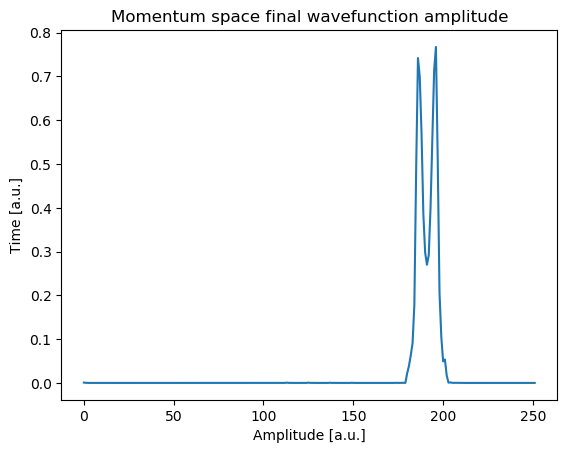

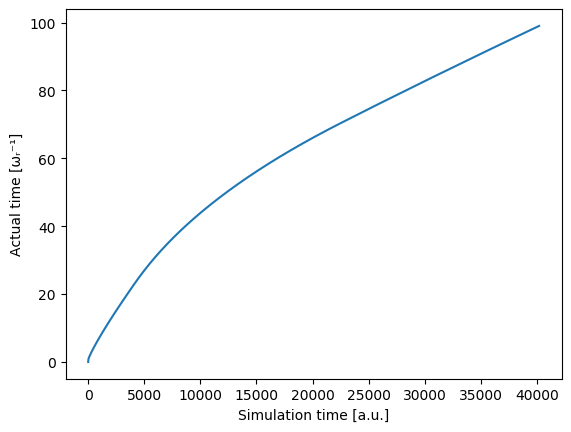

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000069754BE0>

In [270]:
PyPlot.figure()
PyPlot.title("Momentum space simulation, hot atom");
PyPlot.ylabel("Momentum [a.u.]");
PyPlot.xlabel("Time [a.u.]");
pcolormesh(abs.(œàf).^2, cmap = üçé)
#PyPlot.savefig("Momentum space hot atom lat dep 9.png");

PyPlot.figure()
PyPlot.title("Momentum space final wavefunction amplitude");
PyPlot.ylabel("Time [a.u.]");
PyPlot.xlabel("Amplitude [a.u.]");
plot(abs.(œàf[:,end]).^2)

# Plot the actual time vs. the integrator steps
PyPlot.figure()
PyPlot.ylabel("Actual time [œâ·µ£‚Åª¬π]");
PyPlot.xlabel("Simulation time [a.u.]");
plot(ts)

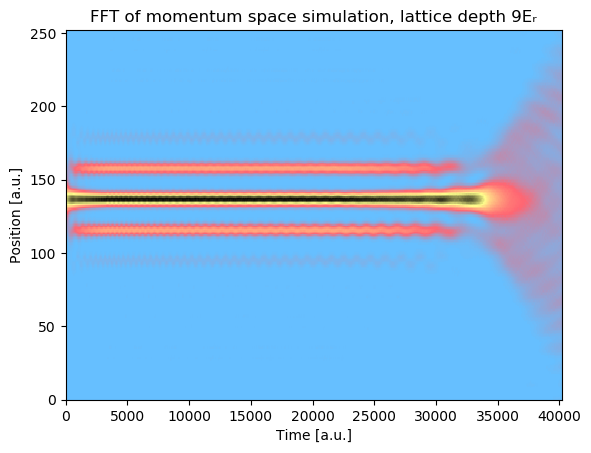

In [271]:
using FFTW
n_dk = params["n_dk"]

œàx = (1+0im).*zeros(size(œàf));
temp = (1+0im).*zeros(size(œàf));
dim = Int(length(temp[:,1])/2);
œàclean = (1+0im).*zeros(size(œàf));
œàclean[n_dk+1:end-n_dk-1,:] = œàf[n_dk+1:end-n_dk-1,:]

for i = 1:length(ts)
    temp[:,i] = fft(œàclean[:,i])
    œàx[1:dim,i] = temp[dim+1:2dim,i];
    œàx[dim+1:2dim,i] = temp[1:dim,i];
end

PyPlot.figure()
PyPlot.title("FFT of momentum space simulation, lattice depth 9E·µ£");
PyPlot.ylabel("Position [a.u.]");
PyPlot.xlabel("Time [a.u.]");
pcolormesh(abs.(œàx).^2, cmap = üçé)
#PyPlot.savefig("FFT of Momentum space hot atom lat dep 9.png");

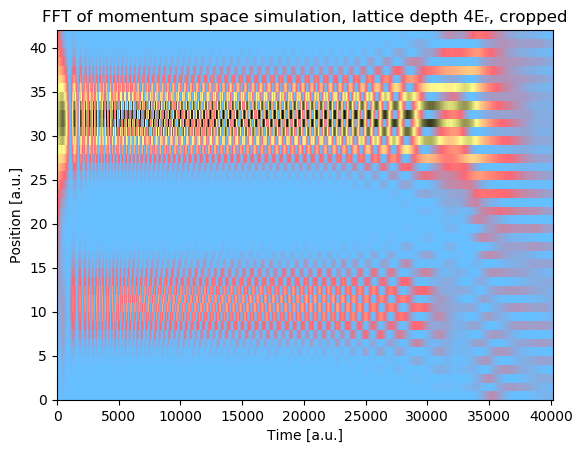

In [272]:
using FFTW
n_dk = params["n_dk"]

cut = 20;
dim = Int(length(œàx[:,1])/2);
œàxcropped = œàx[dim-cut:dim+cut+1, :];

PyPlot.figure()
PyPlot.title("FFT of momentum space simulation, lattice depth 4E·µ£, cropped");
PyPlot.ylabel("Position [a.u.]");
PyPlot.xlabel("Time [a.u.]");
pcolormesh(abs.(real(œàxcropped)).^2, cmap = üçé)
#PyPlot.savefig("FFT of Momentum space hot atom cropped lat dep 9.png");

In [273]:
#This function takes the momentum space simulation, zero pads additional momentum states
#onto the wavefunction for each timestep, then takes the Fourier transform and returns
#the real space wavefunction
function zero_pad(œà,xtra)
    s = size(œà)
    œànew = 1.0im.*zeros((s[1]+2xtra,s[2]));
    œànew[xtra+1:xtra+s[1],:] = œà;
    temp = 1.0im.*zeros(s[1]+2xtra);
    dim = Int(length(temp)/2);
    œàx = 1.0im.*zeros(size(œànew));
        
    for i = 1:s[2]
        temp = fft(œànew[:,i]);
        œàx[1:dim,i] = temp[dim+1:2dim];
        œàx[dim+1:2dim,i] = temp[1:dim];
    end
    return œàx
end

n_dk = params["n_dk"];
nx = 80;
@time œàxpadded = zero_pad(œàf,nx*n_dk);
print(size(œàxpadded))
2*n_dk*(n_k+nx)

 13.571988 seconds (2.81 M allocations: 4.514 GiB, 3.72% gc time)
(1212, 40189)

1212

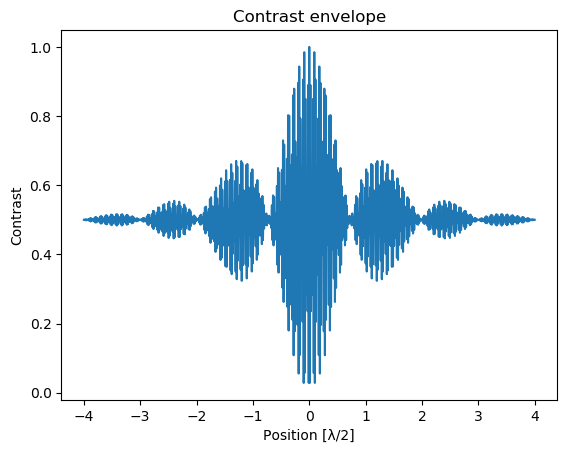

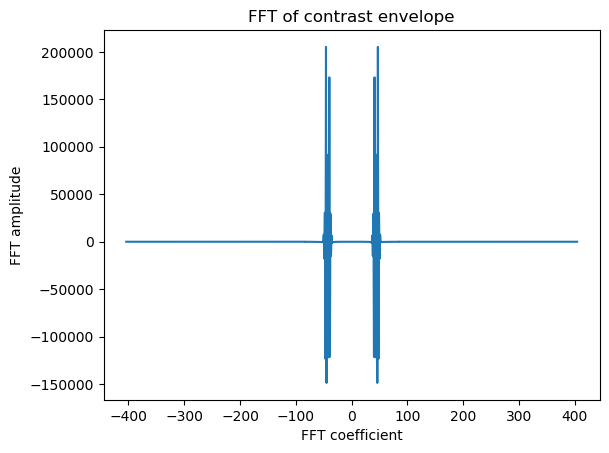

0.009900990099009901

PyObject Text(0.5, 1, 'FFT of contrast envelope')

In [274]:
using Statistics

œàint = 1.0im.*zeros(length(œàxpadded));
n_dk = params["n_dk"];
n_k = params["n_k"];
dx = 1/(nx+n_k);
print(dx)
n_lat = 4;
n_int = Int(round(n_lat/dx));
int = zeros(2n_int+1);

for i = -n_int:n_int
    int[i+n_int+1] = normalize(œàxpadded[:,end]+circshift(œàxpadded[:,end],i));
end

plot(dx.*(-n_int:n_int),(int.* 0.5*Statistics.mean(int)^(-1) ))
PyPlot.ylabel("Contrast");
PyPlot.xlabel("Position [Œª/2]");
PyPlot.title("Contrast envelope")
PyPlot.savefig("Int_BO.png");
figure()
plot(-n_int:n_int,fft(int .- Statistics.mean(int)))
PyPlot.xlabel("FFT coefficient");
PyPlot.ylabel("FFT amplitude");
PyPlot.title("FFT of contrast envelope")

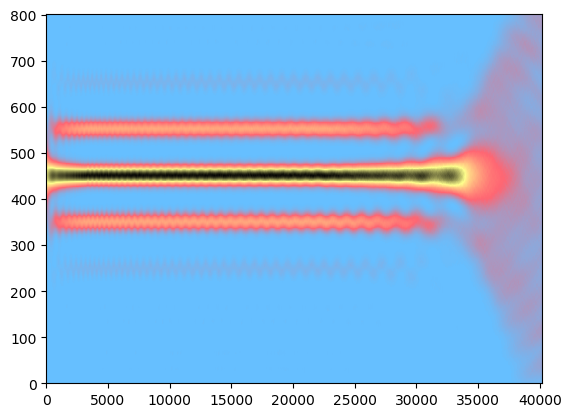

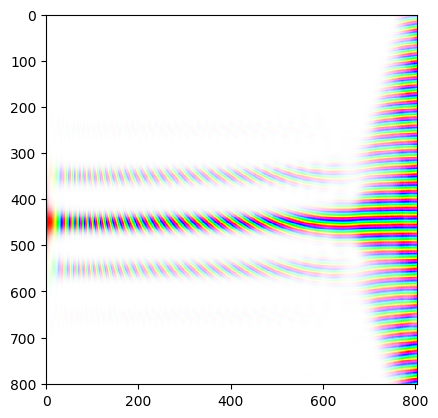

‚îå Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
‚îÇ   caller = top-level scope at In[275]:13
‚îî @ Core In[275]:13
‚îå Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
‚îÇ   caller = top-level scope at In[275]:13
‚îî @ Core In[275]:13


In [275]:
cut = 400;
dim = Int(length(œàxpadded[:,1])/2);
œàxPaddedAndCropped = œàxpadded[dim-cut:dim+cut+1, :];
PyPlot.figure()
pcolormesh(abs.(œàxPaddedAndCropped).^2, cmap = üçé)
PyPlot.savefig("Amp_N_Bloch_2.png");

for i = 1:length(œàxPaddedAndCropped[:,1])
    if i%2==0
        œàxPaddedAndCropped[i,:] = œàxPaddedAndCropped[i,:].*-1;
    end
end

#Plot phase of the wavefunction
my_cmap=matplotlib[:cm][:get_cmap]("hsv",100)
ang = angle.(œàxPaddedAndCropped);
#ang = atan.(imag.(œàxPaddedAndCropped), real.(œàxPaddedAndCropped));
ang_max = maximum(ang);
ang_min = minimum(ang);
ang = (ang.-ang_min)./(ang_max - ang_min);
colors = my_cmap(ang);

Px = abs.(œàxPaddedAndCropped).^2;
for j = 1:length(colors[1,:,1])
    m = maximum(Px[:,j]);
    colors[:,j,4] = Px[:,j]./m;
end

PyPlot.figure()
imshow(colors[:,1:50:end,:])
PyPlot.savefig("Phase_N_Bloch_2.png");

In [276]:
using DelimitedFiles

writedlm("WavefunctionReal55.CSV", real.(œàxPaddedAndCropped[:,1:50:end]),',')
writedlm("WavefunctionIm55.CSV", imag.(œàxPaddedAndCropped[:,1:50:end]),',')